In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml
from collections import Counter
from networkx.algorithms.community import louvain_communities

from helpers.linkage import *
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
import seaborn as sns
from helpers.networks import *
from helpers import style 
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.spatial.distance import euclidean
from scipy.stats import linregress
import igraph as ig

from fastdtw import fastdtw
import stumpy
#    gc_res = np.mean([v[0]['ssr_ftest'][1] for k,v in gc_res.items()])

style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())

In [2]:
dists = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/dists-speech-bound-250',sep='\t')
data = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/data-speech-level-full.tsv',sep='\t')   
keys = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/keys-speech-bound-250',sep='\t')
labels = dict(zip(keys.index,keys.label))
labels_reverse =dict(zip(labels.values(),labels.keys()))

In [3]:
dists.index = pd.to_datetime(data.date,infer_datetime_format=True)
dists = {q:_.to_numpy() for q,_ in dists.groupby(dists.index.to_period('Q')) if len(_) > 100}
timestamps = sorted(list(set(dists.keys())))
del data

In [71]:
networks = []
edges = []

for c,date in tqdm(enumerate(dists)):
    theta = dists[date]
    prominence = {labels[c]:i for c,i in enumerate(theta.mean(axis=0))}

    theta = mutual_information(theta, topn=5)[0]
    g,comm,edge_df = get_network_from_mi_theta(mi_theta=theta,weight_threshold=0,node_text='labels',labels=labels)
    edge_df['p'] = date
    edges.append(edge_df)
    g = g.to_networkx()
    community_labels = louvain_communities(g)
    nx.set_node_attributes(g, community_labels, 'community')
    
    networks.append(g)

171it [02:05,  1.36it/s]


In [5]:
# Calculate temporal node-level neighborhood similarity using Jaccard similarity coefficient with NetworkX
def calculate_temporal_node_neighborhood_similarity(networks, num_previous_networks):
    node_scores = []

    for i in range(len(networks)):
        graph = networks[i]
        neighborhood_similarities = {}

        if i > 0:
            prev_graphs = networks[max(0, i-num_previous_networks):i]  # Consider the specified number of previous networks, or fewer if not available

        for node in graph.nodes(data=True):
            name = node[1]['name']
            node = node[0]
            neighbors = set(graph.neighbors(node))

            if i > 0:
                similarity_scores = []
                for prev_graph in prev_graphs:
                    # Check if the node exists in both the current and previous graph
                    if node in prev_graph:
                        prev_neighbors = set(prev_graph.neighbors(node))
                        similarity = len(neighbors.intersection(prev_neighbors)) / len(neighbors.union(prev_neighbors))
                        similarity_scores.append(similarity)

                avg_similarity = sum(similarity_scores) / len(similarity_scores) if similarity_scores else 0.0
                neighborhood_similarities[name] = avg_similarity
            else:
                neighborhood_similarities[name] = 1.0  # If it's the first network, consider the neighborhood as completely stable

        node_scores.append(neighborhood_similarities)

    return node_scores


In [60]:
struc_eqv = calculate_temporal_node_neighborhood_similarity(networks, 5)

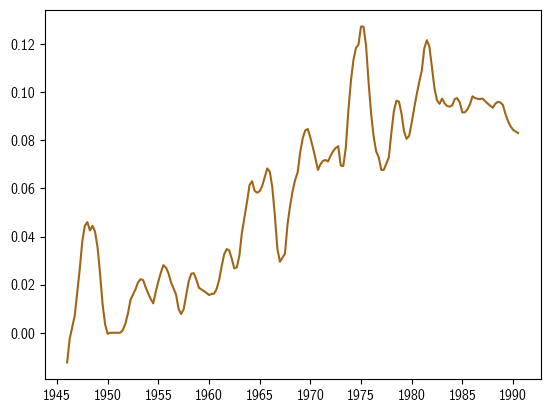

In [64]:
target = 'austerity'
x = [x.to_timestamp() for x in timestamps]
y = [i[target] if target in i.keys() else 0 for i in struc_eqv]
y = adaptive_filter(y,span=72)
plt.plot(x,y)

In [17]:
def identify_node_pairs(networks):
    node_pairs_dict = {}
    for index, network in enumerate(networks):
        node_pairs = list(set(network.edges()))
        node_pairs_dict[index] = node_pairs
    return node_pairs_dict

In [18]:
npd = identify_node_pairs(networks=networks)

In [53]:
labels_reverse['austerity']

186

In [54]:
nb ={t:[node[0] if node[1] == 186 else node[1] for node in n] for t,n in npd.items()}

In [55]:
nnc = []

for i in range(len(timestamps)):

    if i == 0:
        continue
    else:
        nodes_current = set(nb[i])
        nodes_previous = [nb[ix] for ix in range(0,i)]
        nodes_previous = set([item for sublist in nodes_previous for item in sublist])
        new_nodes = [n for n in nodes_current if n not in nodes_previous]
        print(timestamps[i],len(set(new_nodes)))
        for n in set(new_nodes):
            print('\t',labels[n])
        nnc.append(len(set(new_nodes)) / len(set(nodes_current)))

1946Q2 0
1946Q4 34
	 proc/legislative proposal
	 higher education
	 international politics
	 civil code
	 spatial planning
	 surinam and antillian affairs
	 nonsem
	 rhet/attention and improvement
	 student benefits
	 rhet/budget
	 minimum wages
	 research and reports
	 marriages
	 wellbeing
	 penal code
	 proc
	 profit taxes
	 development aid
	 proc
	 tax office
	 civil service wages
	 publicity (wob)
	 rhet/argumentation
	 nonsem
	 regional planning
	 municipal governance
	 proc/legislative modifications
	 international politics
	 municipal borders
	 compulsary education
	 projects and plans
	 united nations
	 international treaties
	 pension fund
1947Q1 0
1947Q2 0
1947Q3 0
1947Q4 10
	 rhet/news sources
	 nonsem
	 budget
	 rhet/systems
	 nonsem
	 education (mbo)
	 nonsem
	 economic investments
	 rhet/aspects
	 proc/house opinions
1948Q1 0
1948Q2 0
1948Q3 0
1948Q4 0
1949Q1 0
1949Q2 0
1949Q3 0
1949Q4 1
	 credit markets and banks
1950Q1 0
1950Q2 0
1950Q3 0
1950Q4 0
1951Q1 0
1951Q2 0
195

In [73]:
edges = pd.concat(edges)

In [235]:


def plot_heatmap(topic=None,min_year=10,filter_nonsem=True,figsize=(6,6)):
    dfe = edges[edges.source == topic]
    dfe['p'] = dfe.p.dt.year
    dfe = dfe.groupby(['target','p']).mean().reset_index()
    dfe = dfe[dfe.groupby("target")['target'].transform('size') > min_year]
    if filter_nonsem:
        dfe = dfe[~dfe.target.str.contains('rhet|nonse|proc')]
    missing = pd.DataFrame([{"target":dfe.target.tolist()[0],"p":y,"weight":0} for y in range(1946,1991) if y not in dfe.p.unique()])
    dfe = pd.concat([dfe,missing])

    dfep = dfe.pivot(index='target',columns='p',values='weight').fillna(0.0)
    f,a = plt.subplots(1,1,figsize=figsize)

    sns.heatmap(dfep,ax=a,cbar=True,cbar_kws={"location":"right","label":"Linkage"},vmin=0,vmax=5,linecolor='white',cmap='Greys',linewidths=5)

    a.set_ylabel('Topics')
    a.set_xlabel('Years')
    a.set_title(f'Diachronic Connections: {topic.capitalize()} (Min. Years = 10)',fontsize=20,pad=15)
    # plt.savefig('figs/connections-heatmap-inflation.png',dpi=250,bbox_inches='tight')
    # plt.show()
    return f,a

/tmp/ipykernel_680/2803726257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe['p'] = dfe.p.dt.year
/tmp/ipykernel_680/2803726257.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfe = dfe.groupby(['target','p']).mean().reset_index()


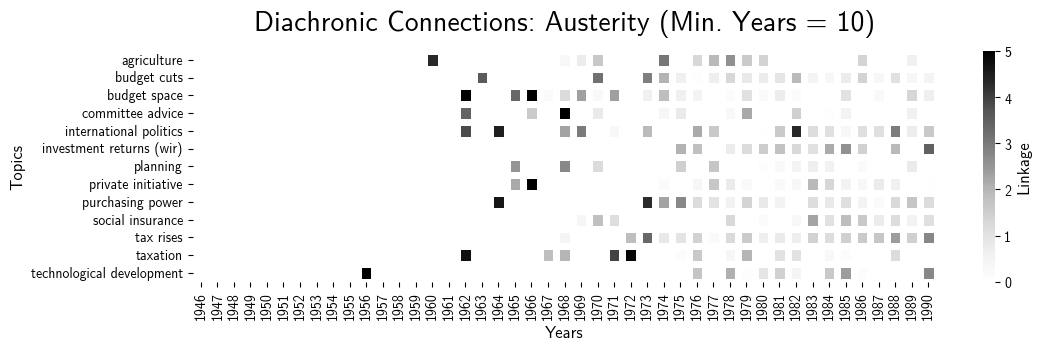

In [241]:
f,a = plot_heatmap("austerity",figsize=(12,3))

/tmp/ipykernel_680/2803726257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe['p'] = dfe.p.dt.year
/tmp/ipykernel_680/2803726257.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfe = dfe.groupby(['target','p']).mean().reset_index()


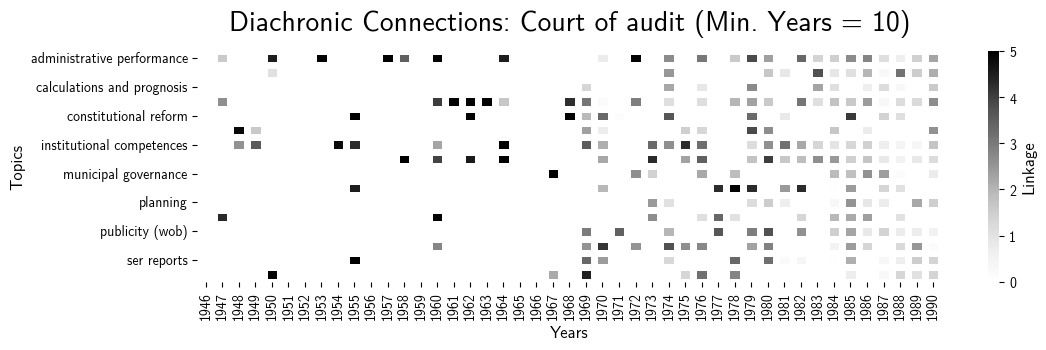

In [244]:
f,a = plot_heatmap("court of audit",figsize=(12,3))